### Library

In [1]:
import pandas as pd
import numpy as np
import os
import re
import matplotlib.pyplot as plt
import seaborn as sns

### Data Load

In [2]:
data_path = '../../data/train/'
train_df = pd.read_csv(os.path.join(data_path, 'train_ratings.csv'))
year_data = pd.read_csv(os.path.join(data_path, 'years.tsv'), sep='\t')
writer_data = pd.read_csv(os.path.join(data_path, 'writers.tsv'), sep='\t')
title_data = pd.read_csv(os.path.join(data_path, 'titles.tsv'), sep='\t')
genre_data = pd.read_csv(os.path.join(data_path, 'genres.tsv'), sep='\t')
director_data = pd.read_csv(os.path.join(data_path, 'directors.tsv'), sep='\t')

In [3]:
# Data shape
print("Train df shape:\n", train_df.shape)
print("Year shape:\n", year_data.shape)
print("Writer shape:\n", writer_data.shape)
print("Title shape:\n", title_data.shape)
print("Genre shape:\n", genre_data.shape)
print("Director shape:\n", director_data.shape)

Train df shape:
 (5154471, 3)
Year shape:
 (6799, 2)
Writer shape:
 (11306, 2)
Title shape:
 (6807, 2)
Genre shape:
 (15933, 2)
Director shape:
 (5905, 2)


In [4]:
print("Train df:\n", train_df.head(5))
print("Year:\n", year_data.head(5))
print("Writer:\n", writer_data.head(5))

Train df:
    user  item        time
0    11  4643  1230782529
1    11   170  1230782534
2    11   531  1230782539
3    11   616  1230782542
4    11  2140  1230782563
Year:
     item  year
0   1348  1922
1  44587  1922
2   4768  1922
3   8235  1923
4   8609  1923
Writer:
    item     writer
0  1237  nm0000005
1  5147  nm0000005
2  7327  nm0000005
3  2068  nm0000005
4  7396  nm0000005


In [5]:
print("Title:\n", title_data.head(5))
print("Genre:\n", genre_data.head(5))
print("Director:\n", director_data.head(5))

Title:
    item                             title
0   318  Shawshank Redemption, The (1994)
1  2571                Matrix, The (1999)
2  2959                 Fight Club (1999)
3   296               Pulp Fiction (1994)
4   356               Forrest Gump (1994)
Genre:
    item     genre
0   318     Crime
1   318     Drama
2  2571    Action
3  2571    Sci-Fi
4  2571  Thriller
Director:
    item   director
0  1237  nm0000005
1  5147  nm0000005
2  7327  nm0000005
3  2068  nm0000005
4  7396  nm0000005


- Writer : 익명
- Title : 연도가 붙어있음 -> year과 비교?
- Genre : 한 작품 당 여러 개인 경우 O
- Director : 익명, 한 작품 당 여러 명인 경우 O

In [6]:
train_df["user"].value_counts().describe()

count    31360.000000
mean       164.364509
std        150.009107
min         16.000000
25%         71.000000
50%        114.000000
75%        200.000000
max       2912.000000
Name: count, dtype: float64

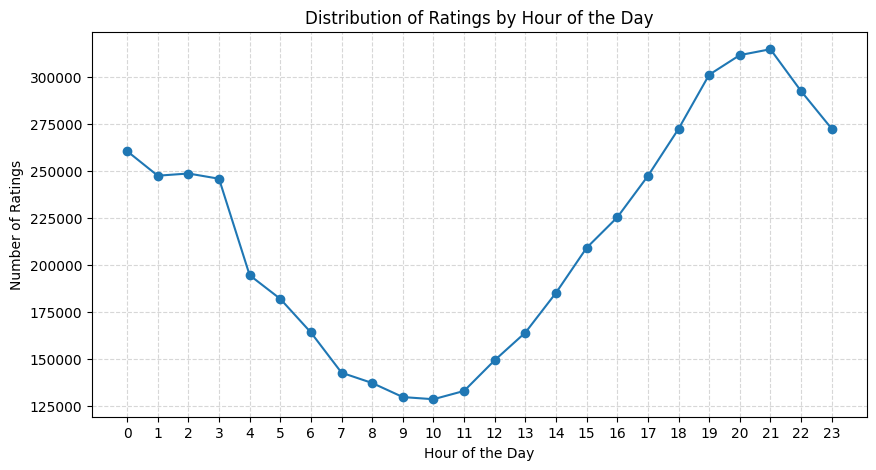

In [26]:
# 시간대별 평가 수
train_df['hour'] = pd.to_datetime(train_df['time'], unit='s').dt.hour
hourly_counts = train_df['hour'].value_counts().sort_index()

plt.figure(figsize=(10, 5))
plt.plot(hourly_counts.index, hourly_counts.values, marker='o')
plt.title('Distribution of Ratings by Hour of the Day')
plt.xlabel('Hour of the Day')
plt.ylabel('Number of Ratings')
plt.xticks(range(24))  # x축에 0~23까지 시간 표시
plt.grid(visible=True, linestyle='--', alpha=0.5)
plt.show()

### Data Merge

In [7]:
year_df = pd.merge(train_df, year_data, on="item", how="left")
writer_df = pd.merge(train_df, writer_data, on="item", how="left")
title_df = pd.merge(train_df, title_data, on="item", how="left")
genre_df = pd.merge(train_df, genre_data, on="item", how="left")
director_df = pd.merge(train_df, director_data, on="item", how="left")

In [8]:
print("Year Missing Value:\n", year_df.isnull().sum())
print("Writer Missing Value:\n", writer_df.isnull().sum())
print("Title Missing Value:\n", title_df.isnull().sum())
print("Genre Missing Value:\n", genre_df.isnull().sum())
print("Director Missing Value:\n", director_df.isnull().sum())

Year Missing Value:
 user       0
item       0
time       0
year    1832
dtype: int64
Writer Missing Value:
 user           0
item           0
time           0
writer    312692
dtype: int64
Title Missing Value:
 user     0
item     0
time     0
title    0
dtype: int64
Genre Missing Value:
 user     0
item     0
time     0
genre    0
dtype: int64
Director Missing Value:
 user             0
item             0
time             0
director    301445
dtype: int64


**Missing Value**
- Year : 1832 -> title에 결측치가 없으니 제목 **(연도)** 값으로 채워넣기
- Writer : 312692
- Title : 없음
- Genre : 없음
- Director : 301445

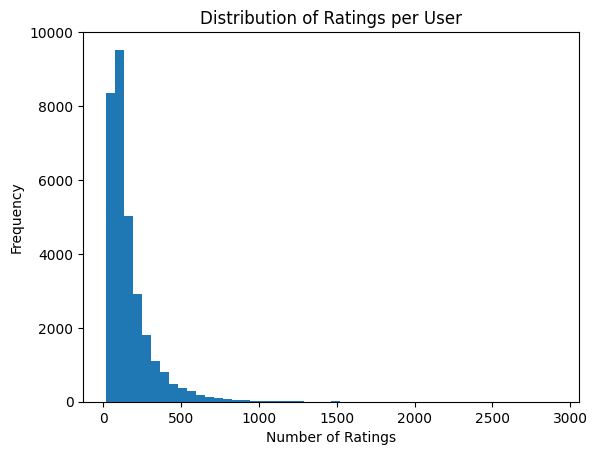

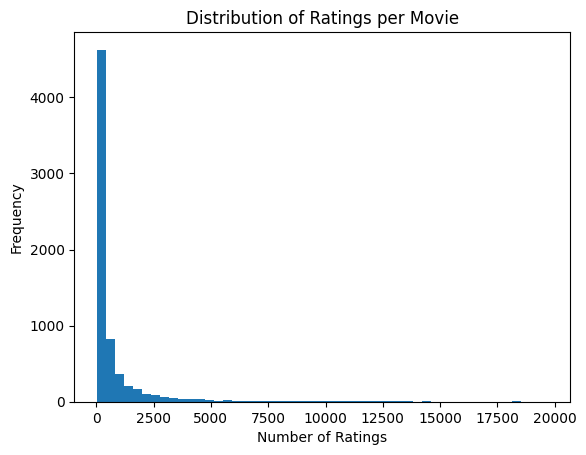

In [9]:
# 사용자별 평가 개수
user_ratings_count = train_df['user'].value_counts()
user_ratings_count.plot(kind='hist', bins=50, title='Distribution of Ratings per User')
plt.xlabel('Number of Ratings')
plt.show()

# 영화별 평가 개수
movie_ratings_count = train_df['item'].value_counts()
movie_ratings_count.plot(kind='hist', bins=50, title='Distribution of Ratings per Movie')
plt.xlabel('Number of Ratings')
plt.show()


- user, item 모두 long tail distribution

item
2571    19699
2959    18437
296     18202
318     18168
356     17339
4993    17237
7153    16656
5952    16387
593     15847
2858    15213
Name: count, dtype: int64


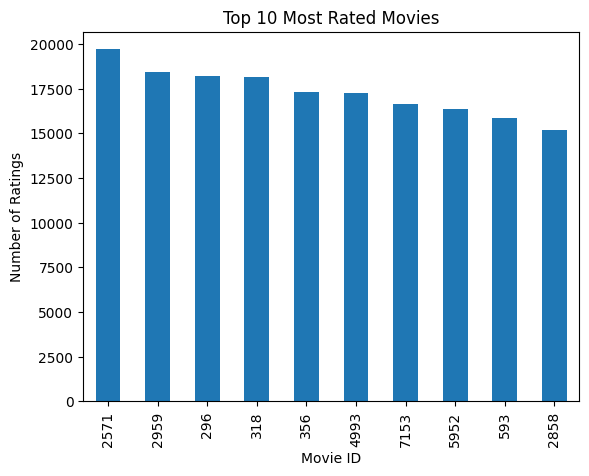

In [10]:
# 가장 많이 평가된 영화 상위 10개
top_movies = movie_ratings_count.head(10)
print(top_movies)

# 상위 10개 영화 시각화
top_movies.plot(kind='bar', title='Top 10 Most Rated Movies')
plt.xlabel('Movie ID')
plt.ylabel('Number of Ratings')
plt.show()

In [11]:
top_movies_titles = title_data[title_data["item"].isin(top_movies.index)]
print(top_movies_titles[["item", "title"]])

   item                                              title
0   318                   Shawshank Redemption, The (1994)
1  2571                                 Matrix, The (1999)
2  2959                                  Fight Club (1999)
3   296                                Pulp Fiction (1994)
4   356                                Forrest Gump (1994)
5  4993  Lord of the Rings: The Fellowship of the Ring,...
6  7153  Lord of the Rings: The Return of the King, The...
7  5952      Lord of the Rings: The Two Towers, The (2002)
8   593                   Silence of the Lambs, The (1991)
9  2858                             American Beauty (1999)


In [12]:
top_movies_genre = genre_data[genre_data["item"].isin(top_movies.index)]
print(top_movies_genre[["item", "genre"]])

    item      genre
0    318      Crime
1    318      Drama
2   2571     Action
3   2571     Sci-Fi
4   2571   Thriller
5   2959     Action
6   2959      Crime
7   2959      Drama
8   2959   Thriller
9    296     Comedy
10   296      Crime
11   296      Drama
12   296   Thriller
13   356     Comedy
14   356      Drama
15   356    Romance
16   356        War
17  4993  Adventure
18  4993    Fantasy
19  7153     Action
20  7153  Adventure
21  7153      Drama
22  7153    Fantasy
23  5952  Adventure
24  5952    Fantasy
25   593      Crime
26   593     Horror
27   593   Thriller
28  2858     Comedy
29  2858      Drama


In [13]:
top_movies_genre.groupby("genre").count()

,item
genre,
Action,3
Adventure,3
Comedy,3
Crime,4
Drama,6
Fantasy,3
Horror,1
Romance,1
Sci-Fi,1


### Year

In [14]:
print("Num of unique year: ", year_data["year"].nunique())
print(year_data["year"].describe())

Num of unique year:  93
count    6799.000000
mean     1992.174732
std        19.052568
min      1922.000000
25%      1985.000000
50%      1999.000000
75%      2006.000000
max      2014.000000
Name: year, dtype: float64


- 1922(min) ~ 2014(max) 까지 한 작품씩은 존재

In [15]:
no_year = set(train_df["item"]) - set(year_data["item"])
len(no_year)

8

In [16]:
train_df[train_df["item"].isin(no_year)].drop_duplicates(subset="item")

,user,item,time
3486,132,6987,1114010962
14766,425,3310,1418071653
22207,614,7243,1125797132
23109,631,8511,1413746154
24877,710,32898,1303626489
29495,775,7065,1113812613
31051,828,119145,1427400133
171596,4276,6988,1234595851


- train_df에 year 없는 item 수 : 8개

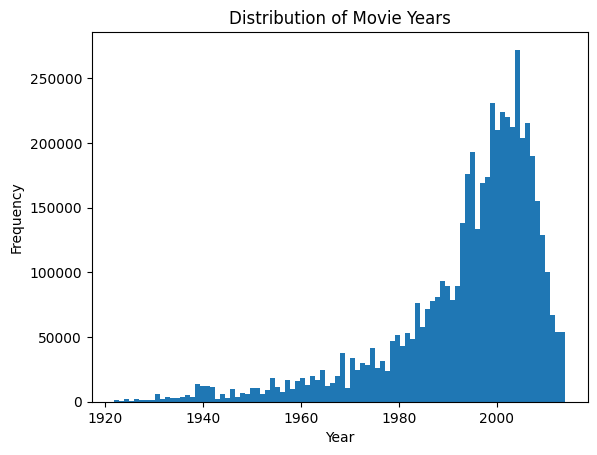

In [17]:
# 연도별 영화 개수 시각화
year_df['year'].plot(kind='hist', bins=90, title='Distribution of Movie Years')
plt.xlabel('Year')
plt.show()

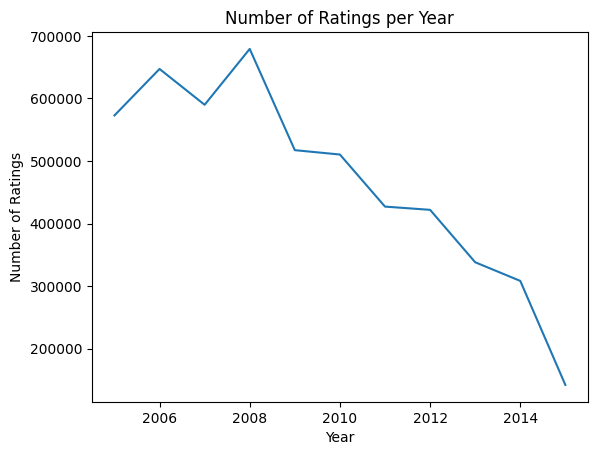

In [18]:
# 시간 데이터를 연도로 변환
year_df['year_rated'] = pd.to_datetime(train_df['time'], unit='s').dt.year

# 연도별 평가 개수 시각화
year_df['year_rated'].value_counts().sort_index().plot(kind='line', title='Number of Ratings per Year')
plt.xlabel('Year')
plt.ylabel('Number of Ratings')
plt.show()

### Title

In [19]:
pattern = r'\(\d{4}\)$'
title_with_year = title_data["title"].apply(lambda x: bool(re.search(pattern, x)))
print(title_data[~title_with_year])

        item                         title
5204  108583     Fawlty Towers (1975-1979)
6295  108548  Big Bang Theory, The (2007-)


- Title에 연도가 포함되지 않은 경우 X
- 예외 2 : Fawlty Towers (1975-1979), Big Bang Theory, The (2007-)
- train_df에 year 없는 item에 포함되지 않음 -> title에 있는 값으로 채우기

### Genre

In [20]:
genre_data["genre"].unique()

array(['Crime', 'Drama', 'Action', 'Sci-Fi', 'Thriller', 'Comedy',
       'Romance', 'War', 'Adventure', 'Fantasy', 'Horror', 'Mystery',
       'Animation', 'Children', 'Film-Noir', 'Musical', 'Western',
       'Documentary'], dtype=object)

In [21]:
genre_per_item = genre_data.groupby("item")["genre"].count()
genre_per_item.describe()

count    6807.000000
mean        2.340679
std         1.114049
min         1.000000
25%         1.000000
50%         2.000000
75%         3.000000
max        10.000000
Name: genre, dtype: float64

- Genre 종류 : 18가지
- max : 10 

In [22]:
genre_data.groupby("genre").nunique()

,item
genre,
Action,1246
Adventure,891
Animation,355
Children,432
Comedy,2408
Crime,924
Documentary,323
Drama,3490
Fantasy,557


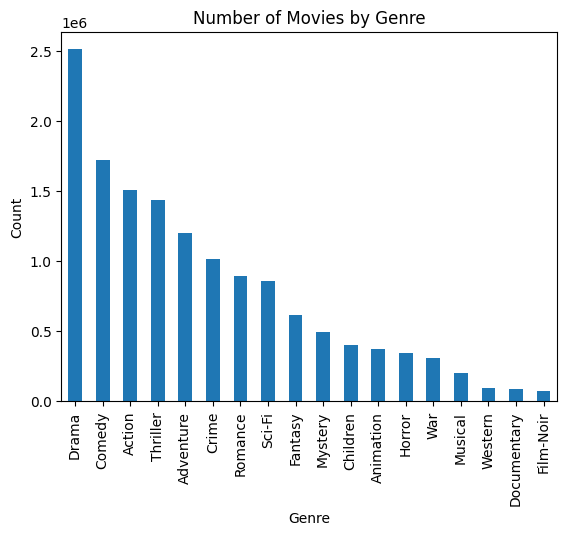

In [23]:
# 장르별 영화 개수 시각화
genre_df['genre'].value_counts().plot(kind='bar', title='Number of Movies by Genre')
plt.xlabel('Genre')
plt.ylabel('Count')
plt.show()

In [24]:
# user별 선호하는 장르를 모아서 리스트로 만들기
preferred_genres = genre_df.groupby("user")["genre"].apply(lambda x: x.mode().tolist())

# genre_df에 선호하는 장르 열 추가 (user 기준으로 병합)
genre_df = genre_df.merge(preferred_genres.rename("preferred_genre"), on="user", how="left")

# 결과 출력
result = genre_df[["user", "preferred_genre"]].drop_duplicates(subset="user")
result.head()


,user,preferred_genre
0,11,[Sci-Fi]
1178,14,[Comedy]
1696,18,[Drama]
1879,25,[Drama]
2112,31,[Adventure]


In [ ]:
# # user별 접한 장르를 모아서 리스트로 만들기
# user_genres = genre_df.groupby("user")["genre"].apply(lambda x: set(x))

# # genre_df에 선호하는 장르 열 추가 (user 기준으로 병합)
# genre_df = genre_df.merge(user_genres.rename("all_genres"), on="user", how="left")

# # 결과 출력
# result = genre_df[["user", "all_genres"]].drop_duplicates(subset="user")
# result.head()

,user,all_genres
0,11,"{War, Mystery, Film-Noir, Romance, Horror, Mus..."
1178,14,"{War, Mystery, Romance, Western, Musical, Adve..."
1696,18,"{War, Mystery, Film-Noir, Romance, Western, Ho..."
1879,25,"{War, Romance, Horror, Action, Western, Musica..."
2112,31,"{War, Mystery, Romance, Western, Horror, Adven..."


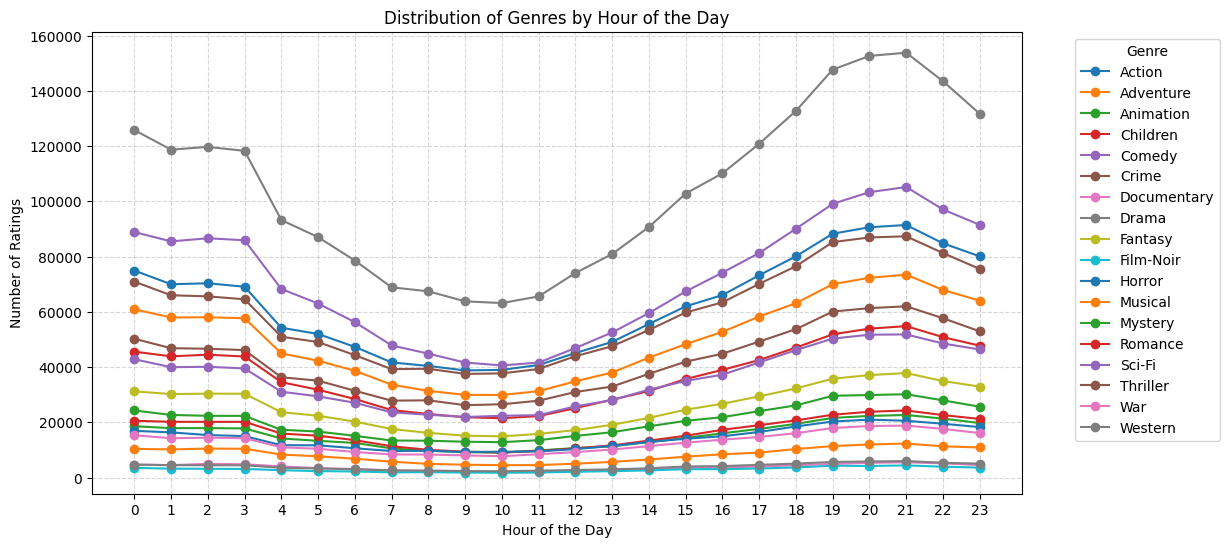

In [27]:
# time 열을 datetime 형식으로 변환하고 시간(hour) 추출
genre_df['datetime'] = pd.to_datetime(genre_df['time'], unit='s')
genre_df['hour'] = genre_df['datetime'].dt.hour

# 시간대별 장르 분포 분석
genre_by_hour = genre_df.groupby(['hour', 'genre']).size().unstack(fill_value=0)

# 시간대별 장르 분포 시각화
genre_by_hour.plot(kind='line', figsize=(12, 6), marker='o')
plt.title('Distribution of Genres by Hour of the Day')
plt.xlabel('Hour of the Day')
plt.ylabel('Number of Ratings')
plt.xticks(range(24))
plt.legend(title='Genre', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(visible=True, linestyle='--', alpha=0.5)
plt.show()

### Writer

In [ ]:
writer_data["item"].value_counts().describe()

count    5648.000000
mean        2.001771
std         1.546859
min         1.000000
25%         1.000000
50%         2.000000
75%         2.000000
max        24.000000
Name: count, dtype: float64

In [ ]:
writer_data["writer"].value_counts().describe()

count    2989.000000
mean        3.782536
std         2.993783
min         2.000000
25%         2.000000
50%         3.000000
75%         4.000000
max        47.000000
Name: count, dtype: float64

### Director

In [ ]:
director_data["item"].value_counts().describe()

count    5503.000000
mean        1.073051
std         0.420017
min         1.000000
25%         1.000000
50%         1.000000
75%         1.000000
max        14.000000
Name: count, dtype: float64

In [ ]:
director_data["director"].value_counts().describe()

count    1340.000000
mean        4.406716
std         3.633030
min         2.000000
25%         2.000000
50%         3.000000
75%         5.000000
max        44.000000
Name: count, dtype: float64